# Исследование успешности игр

Задачи проекта: используя исторические данные о продажах компьютерных игр, оценки пользователей и экспертов, жанры и платформы, выявить закономерности, определяющие успешность игры

### Оглавление
1. [Изучение общей информации](#1)  
2. [Предобработка данных](#2)  
3. [Исследовательский анализ данных.](#3)  
    3.1. [Продажи по годам.](#31)  
    3.2. [Продажи по платформам.](#32)  
    3.3. [Пзаимосвязь продаж и отзывов критиков, пользователей](#33)  
    3.4. [Игры по жанрам](#34)  
4. [Портрет пользователя каждого региона.](#4)  
    4.1. [Самые популярные платформы по регионам.](#41)  
    4.2. [Самые популярные жанры по регионам](#42)  
    4.3. [Взаимосвязь рейтинга ESRB и продаж по регионам.](#43)  
5. [Проверка гипотез](#5)  
6. [Общий вывод](#6)

###  <a id='1'></a> 1.  Изучение общей информации

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st

In [32]:
games = pd.read_csv('datasets/games.csv')

print(games.info())
games.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB
None


,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


#### Выводы

1. В столбцах 'Name', 'Year_of_Release', 'Critic_Score', 'User_Score', 'Rating' есть пропущенные значения.
2. В именах столбцов присутствуют буквы верхнего и нижнего регистра.
3. Столбец 'Year_of_Release' (год выпуска) имеет тип данных float. По описанию данных в данном столбце хранится целочисленная информация.
4. Столбец 'User_Score'(оценка пользователей) имеет тип данных object. По описанию данных в данном столбце хринтся численная информация.

###  <a id='2'></a>2. Предобработка данных

In [33]:
#приведем название колонок в нижний регистр
games.columns = games.columns.str.lower()

#удалим строки с пропущенным значениями в столбцах 'name', 'year_of_release'
games.dropna(subset = ['name', 'year_of_release'], inplace = True)

#изменим тип данных столбца 'year_of_release' на int
games['year_of_release'] = games['year_of_release'].astype('int')

#изменим тип данных столбца 'user_score' на численный
#не числовые значения ('tbd') заменим на NaN
games['user_score'] = pd.to_numeric(games['user_score'], errors = 'coerce')

#добавим столбец total_sales - суммарные продажи во всех регионах
games['total_sales'] = (games['na_sales'] + 
                        games['eu_sales'] + 
                        games['jp_sales'] + 
                        games['other_sales'])


1. Пропуски в столбцах 'name', 'year_of_release' удалим, т.к. они составляют маленький процент от всех данных.
2. Пропуски в столбцах 'Critic_Score', 'User_Score', 'Rating' оставим NaN. Строки с пропусками составляют до 50% данных - удалять нельзя. При заполнении пропусков медианой/средним дальнейшие оценки по данным столбцам будут некорректными.
3. Значения 'tbd' в столбце 'user_score' заменим на NaN, т.к. tbd означает, что рейтинг будет определен позже, на данный момент оценки нет.

###  <a id='3'></a>3. Исследовательский анализ данных

####  <a id='31'></a>3.1. Исследуем продажи по годам

In [34]:
#количество выпускаемых игр по годам
print('Количество выпускаемых игр по годам:')

(games.pivot_table(
    columns = 'year_of_release', 
    values = 'name', 
    aggfunc = 'count'))

Количество выпускаемых игр по годам:


year_of_release,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,...,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
name,9,46,36,17,14,14,21,16,15,17,...,1197,1427,1426,1255,1136,653,544,581,606,502


Количество выпускаемых игр по годам можно условно разделить на 4 периода:
1. 1980 - 1993. Видеоигры только зараждаются, выпускается маленькое количество игр в год (в среднем 27 игр в год).
2. 1994 - 2001. В 1994 г. вышло в 2 раза больше игр, чем в 1993. Количество выпускаемых игр растет, выпускается около 305 игр в год.
3. 2002 - 2011. Пик популярности видеоигр - 1075 в год.
4. 2012 - 2016. В 2012 году наблюдается резкий спад выпускаемых игр (в 2 раза). В этот период выпускают около 577 игр в год.

In [35]:
#суммарные продажи по платформам
#для дальнейшего исследования возьмем первые 6 платформ с наибольшими продажами
platfroms_top_total_sales = (games
                             .pivot_table(columns = 'platform',
                                          values = 'total_sales', 
                                          aggfunc = 'sum')
                             .T
                             .sort_values('total_sales', ascending = False)
                             .head(6))

platfroms_top_total_sales

,total_sales
platform,
PS2,1233.56
X360,961.24
PS3,931.34
Wii,891.18
DS,802.78
PS,727.58


In [36]:
#в переменную запишем данные по платформам с наибольшими суммарными продажами
games_top_platforms = games.query('platform in @platfroms_top_total_sales.index')

#по каждой платформе посчитаем суммарные продажи по годам
games_top_platforms_total_sales_per_year = (games_top_platforms
                                            .pivot_table(
                                                index = ['platform'], 
                                                columns = 'year_of_release', 
                                                values = 'total_sales', 
                                                aggfunc = 'sum'))


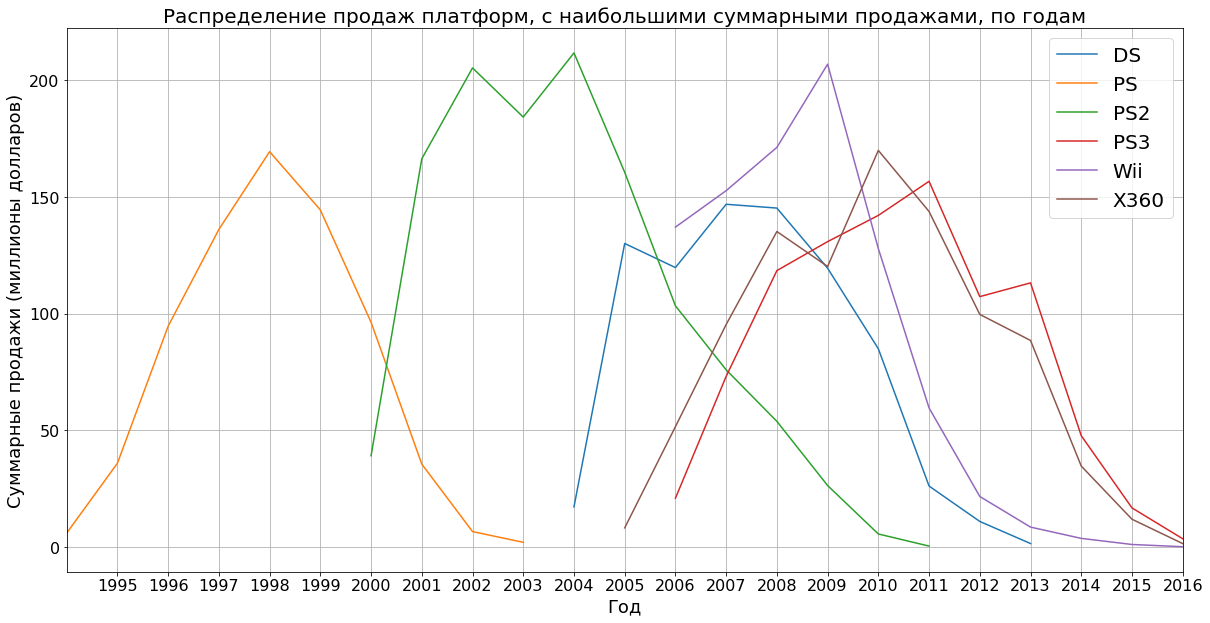

In [37]:
#построение графика
(games_top_platforms_total_sales_per_year.T.plot(
    figsize = (20,10), 
    xlim = (1994, 2016)))

#добавление сетки
plt.grid()

#добавление заголовка и подписей осей
plt.title('Распределение продаж платформ, с наибольшими суммарными продажами, по годам', fontsize = 20)
plt.xlabel('Год', fontsize=18)
plt.ylabel('Суммарные продажи (миллионы долларов)', fontsize=18)

#зададим шаг, размер шрифта подписей по осям
plt.xticks(range(1995, 2017, 1), fontsize=16)
plt.yticks(range(0, 250, 50), fontsize=16)

#зададим размер шрифта легенды
plt.legend(fontsize = 20)

In [38]:
games_top_platforms_total_sales_per_year.T.fillna('-')

platform,DS,PS,PS2,PS3,Wii,X360
year_of_release,,,,,,
1985,0.02,-,-,-,-,-
1994,-,6.03,-,-,-,-
1995,-,35.96,-,-,-,-
1996,-,94.7,-,-,-,-
1997,-,136.17,-,-,-,-
1998,-,169.49,-,-,-,-
1999,-,144.53,-,-,-,-
2000,-,96.37,39.17,-,-,-
2001,-,35.59,166.43,-,-,-


#### Выводы

1. Цикл жизни платформы 10-11 лет. 
2. В первые 1-2 года, после выпуска платформы, продажи небольшие. Следующие 4-5 года - время высоких продаж, которые затем резко идут на спад.

Актуальным периодом будем считать данные с 2012 года.

In [39]:
#в переменную запишем данные с 2012 года включительно
#уберем платформы DS и PSP: в 2016 году суммарные продажи этих платформ равны 0

games_relevant = games.query('(year_of_release > 2011) and (platform != "DS") and (platform != "PSP")').copy()


####  <a id='32'></a>3.2. Исследуем продажи по платформам

In [40]:
#суммарные продажи актуальных платформ по годам
games_relevant_pivot = games_relevant.pivot_table(
                                                  index = ['platform'], 
                                                  columns = 'year_of_release', 
                                                  values = 'total_sales', 
                                                  aggfunc = 'sum')

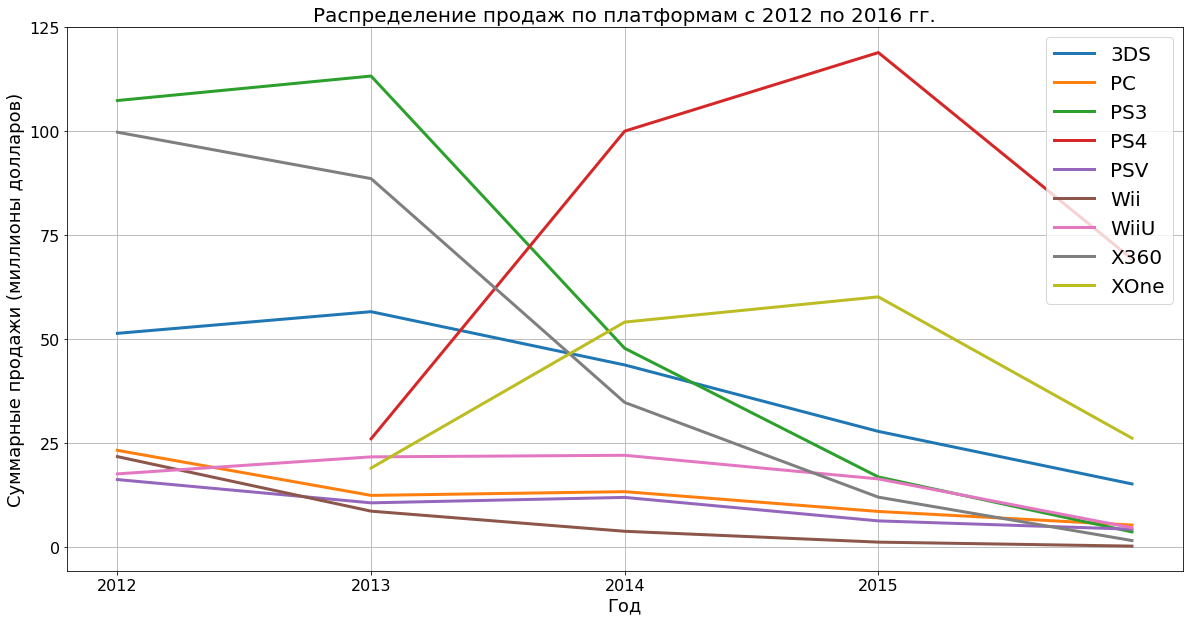

In [41]:
#построим график распределения продаж по годам по актуальным платформам
games_relevant_pivot.T.plot(figsize = (20,10), linewidth = 3)

#добавим сетку
plt.grid()

#добавим заголовок, подписи осей
plt.title('Распределение продаж по платформам c 2012 по 2016 гг.', fontsize = 20)
plt.xlabel('Год', fontsize=18)
plt.ylabel('Суммарные продажи (миллионы долларов)', fontsize=18)

#зададим шаг, размер шрифта подписей по осям
plt.xticks(range(2012, 2016, 1), fontsize=16)
plt.yticks(range(0, 150, 25), fontsize=16)

#зададим размер шрифта легенды
plt.legend(fontsize = 20)

In [42]:
games_relevant_pivot.fillna('-')

year_of_release,2012,2013,2014,2015,2016
platform,,,,,
3DS,51.36,56.57,43.76,27.78,15.14
PC,23.22,12.38,13.28,8.52,5.25
PS3,107.36,113.25,47.76,16.82,3.60
PS4,-,25.99,100.00,118.90,69.25
PSV,16.19,10.59,11.90,6.25,4.25
Wii,21.71,8.59,3.75,1.14,0.18
WiiU,17.56,21.65,22.03,16.35,4.60
X360,99.74,88.58,34.74,11.96,1.52
XOne,-,18.96,54.07,60.14,26.15


1. По продажам лидирует PS4, в два раза меньше собирает XOne.
2. Продажи игр на платформе Wii, X360 приближаются к 0.
3. Продажи по всем платформам падают.
4. Потенциально прибыльные платформы: PS4, XOne, 3DS.

In [43]:
#для отображения на графике боксплотов в порядке возрастания медианы по суммарным продажам:
#в переменную platform_order_by_total_sales запишем платформы в порядке возрастания медианы
platform_order_by_total_sales = (games_relevant
                                 .groupby(by="platform")["total_sales"]
                                 .median()
                                 .sort_values(ascending=False)
                                 .index)

#каждой платформе присвоим число в порядке возрастания медианы
platform_order_number = dict(zip(platform_order_by_total_sales,
                                 range(len(platform_order_by_total_sales))))

#создадим столбец 'platform_number' в который запишем число, присвоенное платформе
games_relevant['platform_number'] = games_relevant['platform'].map(platform_order_number)


Text(0, 0.5, 'Платформы')

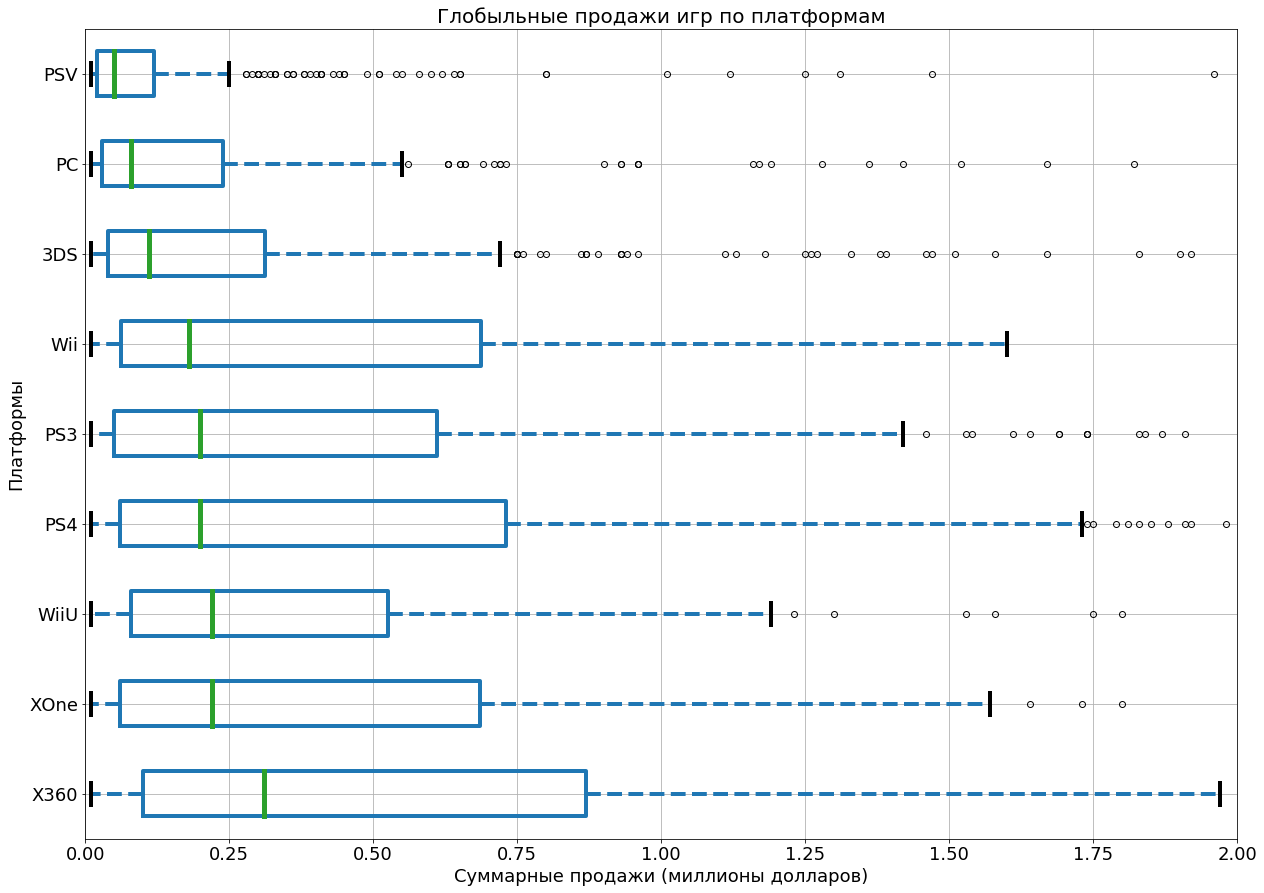

In [44]:
#построение графика «ящик с усами» по глобальным продажам каждой игры и разбивкой по платформам
fig, ax = plt.subplots(figsize=(20,15))

#строим boxplot: группируем по номеру, присовенному каждой платформе в порядке возрастания медианы
games_relevant.boxplot(column = ['total_sales'], 
                       by = 'platform_number', 
                       ax = ax, 
                       vert = False, 
                       whiskerprops = dict(linestyle = '--', linewidth = 4), 
                       boxprops = dict(linewidth = 4), 
                       capprops = dict(linewidth = 4), 
                       medianprops = dict(linewidth = 5))

#задаем ограничение по оси x
plt.xlim(0, 2)

#задаем размер шрифта подписей 
#числовые подписи на оси y меняем на название платформ
plt.xticks(fontsize = 18)
plt.yticks([1, 2, 3, 4, 5, 6, 7, 8, 9], platform_order_by_total_sales)
plt.yticks(fontsize = 18)

#задаем название графика и подписи
plt.suptitle('')
plt.title('Глобыльные продажи игр по платформам', fontsize = 20)
plt.xlabel('Суммарные продажи (миллионы долларов)', fontsize=18)
plt.ylabel('Платформы', fontsize=18)

#### Выводы

1. Медианые продажи платформ Wii, PS3, PS4, WiiU, XOne примерно одинаковы и в среднем равны 0,21 млн. долларов.
2. Самая высокая медианые продажи у платформы X360 - 0,31 млн. долларов.
3. Самые низкие медианые продажи у PSV - 0,05 , PC - 0,08 , 3DS - 0,11 млн. долларов.
4. Платформы X360, PS4 имеют большой разброс продаж по играм. 25% всех игр имеют суммарные продажи: 1)на платформе X360 - от 0,9 до 1,98 млн. долларов; 2) на PS4 - от 0,7 до 1.7 млн. долларов;
5. Платформы XOne и Wii похожи по продажам: 25 % всех игр на Wii и XOne продаются в пределах- от 0,68 до 1,6 млн. долларов. И практически все игры собирают до 1,6 млн. долларов.
6. Платформы PSV, PC, 3DS имеют маленькие разброс суммарных продаж по играм. Подавляющее большинство игр на PSV (не считая выбросов) имеют продажи до 0,25 млн. долларов, PC -  0,57 млн. долларов, 3DS - 0,7 млн. долларов.

####  <a id='33'></a>3.3. Исследуем взаимосвязь продаж и отзывов критиков, пользователей

In [45]:
#в качестве популярной платформы выберем PS4
games_relevant_PS4 = games_relevant.query('platform == "PS4"')

#в переменную запишем только нужные для анализа данные
games_relevant_PS4_corr = games_relevant_PS4[{'critic_score', 'user_score', 'total_sales'}]

#считаем корреляцию между общими продажами, отзывами критиками, отзывами пользователей
print('Корреляция между продажами, оценками критиков, оценками пользователей в разрезе PS4')
games_relevant_PS4_corr.corr()

Корреляция между продажами, оценками критиков, оценками пользователей в разрезе PS4


,total_sales,critic_score,user_score
total_sales,1.000000,0.406568,-0.031957
critic_score,0.406568,1.000000,0.557654
user_score,-0.031957,0.557654,1.000000


Text(0, 0.5, 'Суммарные продажи (миллионы долларов)')

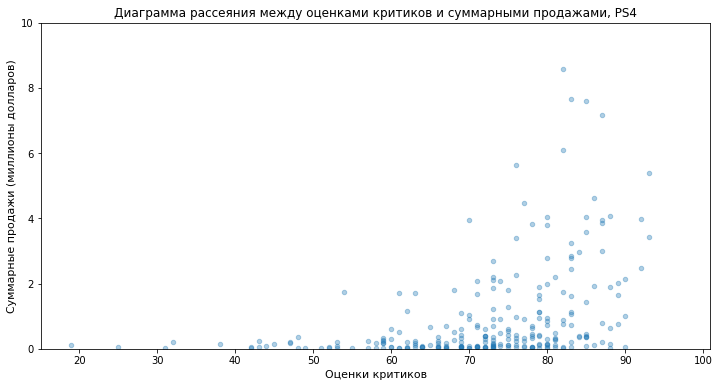

In [46]:
#функция, которая возвращает диаграмму рассеяния
def make_scatter_plot(table, x_col, y_col):
    return (table.plot( 
                       x = x_col,
                       y = y_col,
                       ylim = (0, 10),
                       kind = 'scatter',
                       figsize = (12,6),
                       alpha = 0.35))

#строим диаграмму рассеяния между оценками критиков и суммарными продажами
make_scatter_plot(games_relevant_PS4_corr, 'critic_score', 'total_sales')

plt.title('Диаграмма рассеяния между оценками критиков и суммарными продажами, PS4', fontsize = 12)
plt.xlabel('Оценки критиков', fontsize=11)
plt.ylabel('Суммарные продажи (миллионы долларов)', fontsize=11)

Text(0, 0.5, 'Суммарные продажи (миллионы долларов)')

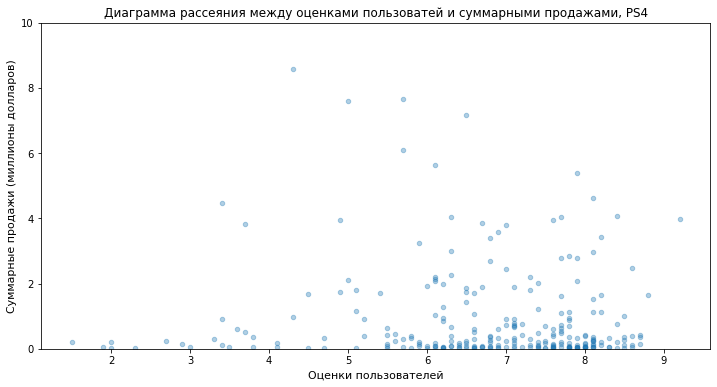

In [47]:
#строим диаграмму рассеяния между отзывами пользователей и суммарными продажами
make_scatter_plot(games_relevant_PS4_corr, 'user_score', 'total_sales')

plt.title('Диаграмма рассеяния между оценками пользоватей и суммарными продажами, PS4', fontsize = 12)
plt.xlabel('Оценки пользователей', fontsize=11)
plt.ylabel('Суммарные продажи (миллионы долларов)', fontsize=11)

Исследование взаимосвязей по платформе PS4: корреляция между оценками критиков и продажами прямо пропорциональна (0,4): чем выше оценки критиков, тем больше продажи. При этом, корреляция между оценками пользователей и продажами обратно пропорционально (-0,03), но она достаточна мала, чтобы считать, что взаимосвязи нет: продажи игр не зависят от оценок пользователей.

In [48]:
#выберем все платформы, кроме PS4
games_relevant_not_PS4 = games_relevant.query('platform != "PS4"')

#оставим только нужные столбцы
games_relevant_not_PS4_corr = games_relevant_not_PS4[{'critic_score', 'user_score', 'total_sales'}]

#корреляция между общими продажами, оценками критиков и пользователей
print('Корреляция между продажами, оценками критиков, оценками пользователей по платформам, кроме PS4')
games_relevant_not_PS4_corr.corr()

Корреляция между продажами, оценками критиков, оценками пользователей по платформам, кроме PS4


,total_sales,critic_score,user_score
total_sales,1.000000,0.284783,0.008987
critic_score,0.284783,1.000000,0.508360
user_score,0.008987,0.508360,1.000000


Text(0, 0.5, 'Суммарные продажи (миллионы долларов)')

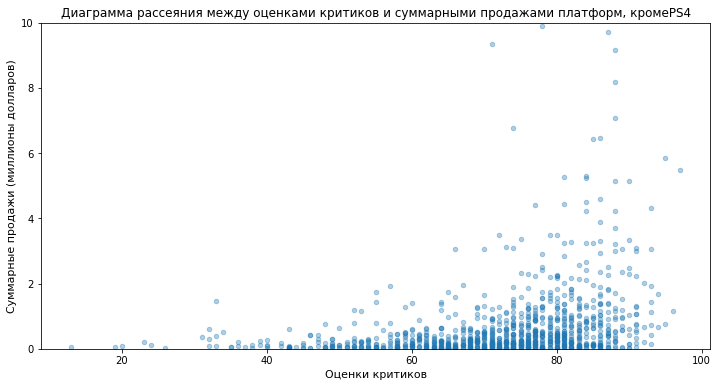

In [49]:
#строим диаграмму рассеяния между отзывами критиков и суммарными продажами
make_scatter_plot(games_relevant_not_PS4_corr, 'critic_score', 'total_sales')

plt.title('Диаграмма рассеяния между оценками критиков и суммарными продажами платформ, кромеPS4', 
          fontsize = 12)

plt.xlabel('Оценки критиков', fontsize=11)
plt.ylabel('Суммарные продажи (миллионы долларов)', fontsize=11)

Text(0, 0.5, 'Суммарные продажи (миллионы долларов)')

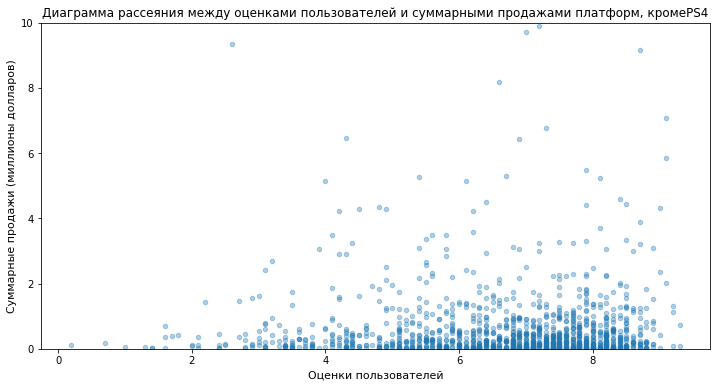

In [50]:
#строим диаграмму рассеяния между отзывами пользователей и суммарными продажами
make_scatter_plot(games_relevant_not_PS4_corr, 'user_score', 'total_sales')

plt.title('Диаграмма рассеяния между оценками пользователей и суммарными продажами платформ, кромеPS4', 
          fontsize = 12)

plt.xlabel('Оценки пользователей', fontsize=11)
plt.ylabel('Суммарные продажи (миллионы долларов)', fontsize=11)

#### Выводы

1. Чем выше оценки критиков, тем больше продажи (коэффициент корреляции: 0,3). В разрезе PS4 (была выбрана нами как одна из самых популярных платформ) взаимосвязь прослеживается еще сильнее (коэффициент корреляции: 0,4).
2. Оценки пользователей не влияют на продажи игр (коэффициент корреляции: 0,009).

#### <a id='34'></a>3.4. Исследуем игры по жанрам

In [51]:
#функция, возвращающая сводную таблице по жанрам
def make_pivot_table_by_genre(col_values, func_to_agg):
    return (games_relevant
            .pivot_table(
                columns = 'genre', 
                values = col_values, 
                aggfunc = func_to_agg)
            .T
            .sort_values(by = col_values, 
                         ascending = False))

#количество игр по жанрам
print('Количество игр по жанрам:')
genre_number_of_games = make_pivot_table_by_genre('name', 'count')
genre_number_of_games.columns = ['number_of_games']
genre_number_of_games

Количество игр по жанрам:


,number_of_games
genre,
Action,953
Role-Playing,339
Sports,256
Adventure,247
Shooter,235
Misc,180
Racing,115
Fighting,105
Platform,83


In [52]:
#выручка по жанрам
print('Суммарные продажи по жанрам:')
genre_total_sales = make_pivot_table_by_genre('total_sales', 'sum')
genre_total_sales

Суммарные продажи по жанрам:


,total_sales
genre,
Action,435.54
Shooter,304.73
Role-Playing,180.91
Sports,179.55
Misc,84.15
Platform,60.31
Racing,53.50
Fighting,44.13
Simulation,34.85


In [53]:
#посчитаем средние продажи по одной игре в каждом жанре
genre_merged = genre_number_of_games.join(genre_total_sales)
genre_merged['total_sales_per_game'] = genre_merged['total_sales'] / genre_merged['number_of_games']

genre_merged.sort_values(by = 'total_sales_per_game', ascending = False)

,number_of_games,total_sales,total_sales_per_game
genre,,,
Shooter,235,304.73,1.296723
Platform,83,60.31,0.726627
Sports,256,179.55,0.701367
Role-Playing,339,180.91,0.533658
Misc,180,84.15,0.467500
Racing,115,53.50,0.465217
Action,953,435.54,0.457020
Simulation,78,34.85,0.446795
Fighting,105,44.13,0.420286


#### Выводы

1. Больше всего игр выпускается в жанрах Action (953 игры). В 3-4 раза меньше выпускается игр в жанрах: Role-Playing (339), Sports (256), Adventure (247), Shooter (235).
2. Самый прибыльные жанры Action (435 млн. долларов), Shooter (304 млн. долларов), Role-Playing	и Sports (по 180 млн. долларов соответственно).
3. Хотя жанр Action и самый прибыльный, но в среднем доход от каждой игры в этом жанре меньше (0,46 млн. долларов).
4. Самые прибыльные жанры в рассчете средних сборов за одну игру: 1) Shooter (1,3 млн. долларов), 2) Platform (0,7 млн. долларов), 3) Sports (0,7 млн. долларов).

### <a id='4'></a> 4. Портрет пользователя каждого региона

#### <a id='41'></a> 4.1. Самые популярные платформы по регионам

In [54]:
#функция, возвращающая первые 5 записей, упорядоченных по убыванию, сводной таблицы
def top_5_by_region(column_val, region):
    return (games_relevant
            .pivot_table(
                columns = column_val, 
                values = region,
                aggfunc = 'sum')
            .T
            .sort_values(
                by = region, 
                ascending = False)
            .head())


print('5 самых популярных платформ в Северной Америке, млн. долларов')
print(top_5_by_region('platform', 'na_sales'))
print('')

print('5 самых популярных платформ в Европе, млн. долларов')
print(top_5_by_region('platform', 'eu_sales'))
print('')

print('5 самых популярных платформ в Японии, млн. долларов')
print(top_5_by_region('platform', 'jp_sales'))


5 самых популярных платформ в Северной Америке, млн. долларов
          na_sales
platform          
X360        140.05
PS4         108.74
PS3         103.38
XOne         93.12
3DS          55.31

5 самых популярных платформ в Европе, млн. долларов
          eu_sales
platform          
PS4         141.09
PS3         106.86
X360         74.52
XOne         51.59
3DS          42.64

5 самых популярных платформ в Японии, млн. долларов
          jp_sales
platform          
3DS          87.79
PS3          35.29
PSV          21.04
PS4          15.96
WiiU         13.01


#### Выводы

1. В Северной Америке самая популярная платформа компании Microsoft(США) X360 (140 млн. долларов), ее платформа преемник XOne находится на 4 месте. Платформы компании Sony(Япония) PS4 и PS3 находятся на 2 и 3 с примерно одинаковыми продажами игр (108 и 103 млн. долларов).
2. В Европе самая популярные платформы PS4 (141 млн. долларов) и PS3(106 млн. долларов). 
3. Все самые популярные платформы в Японии производятся японскими фирмами Sony(PS3, PSV, PS4) и Nintendo (3DS, WiiU). Самая популярная платформа 3DS(88 млн.долларов). Платформа PS4 находится на 4 месте (16 млн. долларов). Пользователи из Японии не так быстро переходят на новые платформы как пользователи из Северной Америки и Европы, это объясняется тем, что платформы для Японского рынка обычно выпускаются на год позже (PS4 - февраль 2014 г.).
4. Самый большой рынок продаж - Северная Америка (500 млн. долларов), самый маленький - Япония (173 млн. долларов).
5. Хотя XOne и PS4 вышли в одно и тоже время для Америки и Европы (ноябрь 2013 г.), PS4(250 млн. долларов) более популярна и прибыльна, чем XOne (145 млн. долларов).

#### <a id='42'></a>4.2. Самые популярные жанры по регионам

In [55]:
print('5 самых популярных жанров в Северной Америке, млн. долларов')
print(top_5_by_region('genre', 'na_sales'))
print('')

print('5 самых популярных жанров в Европе, млн. долларов')
print(top_5_by_region('genre', 'eu_sales'))
print('')

print('5 самых популярных жанров в Японии, млн. долларов')
print(top_5_by_region('genre', 'jp_sales'))

5 самых популярных жанров в Северной Америке, млн. долларов
              na_sales
genre                 
Action          177.00
Shooter         144.77
Sports           81.38
Role-Playing     60.65
Misc             38.13

5 самых популярных жанров в Европе, млн. долларов
              eu_sales
genre                 
Action          158.43
Shooter         113.47
Sports           68.84
Role-Playing     46.76
Racing           27.29

5 самых популярных жанров в Японии, млн. долларов
              jp_sales
genre                 
Role-Playing     59.12
Action           49.18
Misc             12.45
Simulation       10.35
Shooter           9.23


#### Выводы

1. Ппользователи из Северной Америки и Европы любят играть в одинаковые жанры: самые популярные Action и Shooter.
2. Самые популярне жанры в Японии: Role-Playing, Action. Жанр Shooter на последнем месте.

#### <a id='43'></a>4.3. Исследование взаимосвязи рейтинга ESRB и продаж по регионам

In [56]:
print('Продажи от игр в заисимости от рейтинга ESRB в Северной Америке, млн. долларов')
print(top_5_by_region('rating', 'na_sales'))
print('')

print('Продажи от игр в заисимости от рейтинга ESRB в Европе, млн. долларов')
print(top_5_by_region('rating', 'eu_sales'))
print('')

print('Продажи от игр в заисимости от рейтинга ESRB в Японии, млн. долларов')
print(top_5_by_region('rating', 'jp_sales'))

Продажи от игр в заисимости от рейтинга ESRB в Северной Америке, млн. долларов
        na_sales
rating          
M         231.57
E         113.44
E10+       75.09
T          66.02

Продажи от игр в заисимости от рейтинга ESRB в Европе, млн. долларов
        eu_sales
rating          
M         193.96
E         111.79
E10+       54.84
T          52.96

Продажи от игр в заисимости от рейтинга ESRB в Японии, млн. долларов
        jp_sales
rating          
E          27.62
T          25.76
M          21.20
E10+        8.19


1. «E» («Everyone») — «Для всех»;
2. «E10+» («Everyone 10 and older») — «Для всех от 10 лет и старше»;
3. «T» («Teen») — «Подросткам»: Игра подходит для лиц от 13 лет и старше;
4. «M» («Mature») — «Для взрослых»: Материалы игры не подходят для подростков младше 17 лет.

#### Выводы

1. Пользователи в Северной Америке и Европе чаще всего покупают игры с рейтингом "M" - "для взрослых" (231 и 193 млн. долларов соответственно), затем идут игры с рейтингом "E" - "для всех" (113 и 111 млн. долларов соответственно). Это можно объяснить тем, что в Северной Америке и Европе довольно популярен жанр Shooting. Играм в этом жанре довольно часто присваивают рейтинг "M".
2. В Японии пользуются популярностью игры с рейтингом "Е" и "Т" - "подросткам" (28 и 26 млн. долларов соответственно), затем идут игры с рейтингом "М" - 21 млн. долларов: в Японии более популярны жанры всех возрастных категорий.

### <a id='5'></a> 5. Проверка гипотез

Средние пользовательские рейтинги платформ Xbox One и PC одинаковые;

1. Нулевая гипотеза H₀: средние пользовательские рейтинги платформ Xbox One и PC одинаковые.
2. Альтернативная гипотеза H₁: средние пользовательские рейтинги платформ Xbox One и PC разные.

In [57]:
np.warnings.filterwarnings('ignore')

games_relevant_XOne = games_relevant.loc[games_relevant['platform'] == 'XOne', 'user_score']
games_relevant_PC = games_relevant.loc[games_relevant['platform'] == 'PC', 'user_score']

#проверка гипотезы
alpha = 0.05

mean_rating = st.ttest_ind(games_relevant_XOne, games_relevant_PC)

print('p-значение:', mean_rating.pvalue)

if (mean_rating.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: nan
Не получилось отвергнуть нулевую гипотезу


Средние пользовательские рейтинги жанров Action (англ. «действие») и Sports (англ. «виды спорта») разные.

1. Нулевая гипотеза H₀: средние пользовательские рейтинги жанров Action и Sports одинаковые.
2. Альтернативная гипотеза H₁: средние пользовательские рейтинги жанров Action и Sports разные.

In [58]:
games_relevant_Sports = games_relevant.loc[games_relevant['genre'] == 'Sports', 'user_score'].dropna()
games_relevant_Action = games_relevant.loc[games_relevant['genre'] == 'Action', 'user_score'].dropna()


#проверка гипотезы
alpha = 0.05

mean_rating = st.ttest_ind(games_relevant_Sports, games_relevant_Action)

print('p-значение:', mean_rating.pvalue)

if (mean_rating.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 3.639495732612309e-26
Отвергаем нулевую гипотезу


#### Вывод

1. Средние пользовательские рейтинги платформ Xbox One и PC одинаковые.
2. Средние пользовательские рейтинги жанров Action и Sports разные.

### <a id='6'></a>6. Общий вывод

1. Цикл жизни игровых платформ составляет 10-11 лет. В первые 1-2 года, после выпуска платформы, продажи небольшие. Следующие 4-5 года - время высоких продаж, которые затем резко идут на спад.

2. Чем выше оценки критиков, тем больше продажи (коэффициент корреляции: 0,3). Оценки пользователей не влияют на продажи игр (коэффициент корреляции: 0,009).

3. Самый прибыльные жанры: Action (435 млн. долларов), Shooter (304 млн. долларов), Role-Playing и Sports (по 180 млн. долларов соответственно).

4. Хотя жанр Action и самый прибыльный, но в среднем доход от каждой игры в этом жанре меньше (0,46 млн. долларов). Самые прибыльные жанры в рассчете средних сборов за одну игру: 1) Shooter (1,3 млн. долларов), 2) Platform (0,7 млн. долларов), 3) Sports (0,7 млн. долларов).

5. Популярность игровых платформ меняется от стране к стране. 

6. В Японии популярны игровые платформы, производимые японскими фирмами Sony(PS3, PSV, PS4) и Nintendo (3DS, WiiU). Самая популярная платформа 3DS(88 млн.долларов). Платформа PS4 находится на 4 месте (16 млн. долларов).

7. В Северной Америке самая популярная платформа компании Microsoft X360 (140 млн. долларов), ее платформа преемник XOne находится на 4 месте. Платформы компании Sony PS4 и PS3 находятся на 2 и 3 с примерно одинаковыми продажами игр (108 и 103 млн. долларов).

8. В Европе самая популярные платформы PS4 (141 млн. долларов) и PS3(106 млн. долларов).

9. Самый большой рынок продаж - Северная Америка (500 млн. долларов), самый маленький - Япония (173 млн. долларов).

10. Хотя XOne и PS4 вышли в одно и тоже время для Америки и Европы (ноябрь 2013 г.), PS4(250 млн. долларов) более популярна и прибыльна, чем XOne (145 млн. долларов).

11. Пользователи Японии отличаются от пользоватей Северной Америки и Европы по жанровым предпочтениям в играх.

12. У пользователей из Северной Америки и Европы любят самые популярные жанры - это Action (177 и 159 млн. долларов) и Shooter (144 и 113 млн. долларов).

13. Самые популярне жанры в Японии: Role-Playing (59 млн. долларов), Action (49 млн. долларов). Жанр Shooter на последнем месте (9 млн. долларов).

14. Пользователи в Северной Америке и Европе чаще всего покупают игры с рейтингом "M" - "для взрослых" (231 и 193 млн. долларов соответственно), затем идут игры с рейтингом "E" - "для всех" (113 и 111 млн. долларов соответственно). Это можно объяснить тем, что в Северной Америке и Европе довольно популярен жанр Shooting. Играм в этом жанре довольно часто присваивают рейтинг "M".

15. В Японии пользуются популярностью игры с рейтингом "Е" и "Т" - "подросткам" (28 и 26 млн. долларов соответственно), затем идут игры с рейтингом "М" - 21 млн. долларов: в Японии более популярны жанры всех возрастных категорий.

16. Средние пользовательские рейтинги платформ Xbox One и PC одинаковые.

17. Средние пользовательские рейтинги жанров Action и Sports разные.